In [1]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [2]:
from pathlib import Path

from math import floor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import jax.numpy as jnp

from jax_canoak.subjects.utils import es as fes

# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_lai
# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_et

%load_ext autoreload
%autoreload 2

In [3]:
site = "US-Wkg"
dir_flux_data = Path(f"../data/fluxtower/{site}")
dir_modis_data = Path(f"../data/modis/{site}")

f_forcing = dir_flux_data / "AMF_US-Wkg_FLUXNET_FULLSET_HH_2004-2021_3-5.csv"
# f_chamber = dir_flux_data / "BouldinAlfalfaForcedDiffusion2018_2021.csv"
f_modis_lai = dir_modis_data / "MCD15A3H" / "filtered_scaled_Lai_500m.csv"
f_modis_le = dir_modis_data / "MOD16A2GF" / "filtered_scaled_LE_500m.csv"

# modis_lai_scale_factor = 0.1
modis_lai_scale_factor = 1
modis_le_scale_factor = 1e4
pixel_ind = 144

# Flux tower data

In [4]:
# Read the dataframe
df = pd.read_csv(f_forcing)

In [5]:
# Get the time frame
df.index = pd.to_datetime(df["TIMESTAMP_END"], format="%Y%m%d%H%M")

In [6]:
# Vegetation height
df["veg_ht"] = 0.4

<Axes: xlabel='TIMESTAMP_END'>

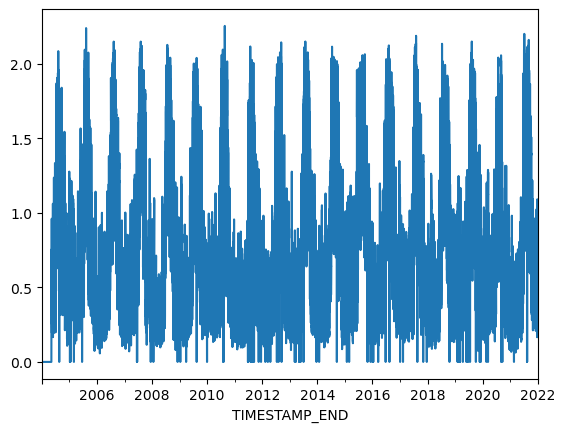

In [7]:
# Calculate vapor pressure from air temperature and relative humidity
es = fes(df["TA_F"].values + 273.15)
# ea = es - df['VPD'].values*1000
df["RH"] = np.clip(df["RH"], a_max=100, a_min=0)
ea = es * df["RH"].values / 100

df["eair"] = ea / 1e3  # kPa
df["eair"].plot()

# Soil respiration

In [8]:
# df_soil = pd.read_csv(f_chamber)
# df_soil["hour"] = df_soil["hhmm"].apply(lambda x: floor(x / 100))
# df_soil["min"] = df_soil["hhmm"] - df_soil["hour"] * 100
# df_soil["doy"] = df_soil["doy"].apply(lambda x: str(x).zfill(3))

In [9]:
# df_soil.index = pd.to_datetime(
#     df_soil["year"].astype(str)
#     + df_soil["doy"].astype(str)
#     + df_soil["hour"].astype(str)
#     + df_soil["min"].astype(str),
#     format="%Y%j%H%M",
# )

In [10]:
# fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
# ax = axes[0]
# df_soil["BA_met f_FD_Flux"].plot(ax=ax, label="FD")
# df_soil["BA_met f_FD_B_Flux"].plot(ax=ax, alpha=0.5, label="FD_B")
# ax.set(
#     title="Forced diffusion chamber flux",
#     ylabel="umol m-2 s-1",
#     # xlim=[df_soil.index[10000], df_soil.index[15000]])
#     xlim=[df_soil.index[-5001], df_soil.index[-1]],
# )
# # ax.legend()
# ax2 = ax.twinx()
# df["P_F"].plot(ax=ax2, color="black", label="precip")
# ax2.set(ylabel="precipitation [mm]", ylim=[12, 0])

# ax = axes[1]
# df["SWC_F_MDS_1"].plot(ax=ax, color="black", label="soil moisture content")
# ax.set(ylabel="Soil moisture content [%]", ylim=[0, 60])

# ax = axes[2]
# # df['SWC_F_MDS_1'].plot(ax=ax2, color='black', label='soil moisture content')
# # ax2.set(ylabel='Soil moisture content [%]', ylim=[60, 0])
# # ax2.invert_yaxis()
# df["TS_F_MDS_1"].plot(ax=ax, color="black", label="Soil temperature")
# ax.set(ylabel="Soil temperature [deg C]", ylim=[0, 30]);

In [11]:
# df_soil = df_soil[["BA_met f_FD_Flux"]]
# df_soil.rename(columns={"BA_met f_FD_Flux": "Rsoil"}, inplace=True)

# MODIS data


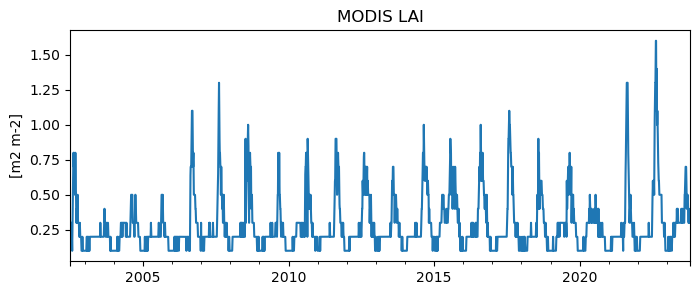

In [12]:
df_modis_lai = pd.read_csv(f_modis_lai, header=None)
df_modis_lai.index = df_modis_lai[2].apply(
    lambda x: pd.to_datetime(x[1:], format="%Y%j")
)
df_modis_lai["LAI"] = df_modis_lai[4 + pixel_ind].apply(
    lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
)
df_modis_lai = df_modis_lai[["LAI"]]
df_modis_lai = df_modis_lai.resample("30min").interpolate()
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df_modis_lai["LAI"].plot(ax=ax)
ax.set(title="MODIS LAI", xlabel="", ylabel="[m2 m-2]");

<Axes: xlabel='2'>

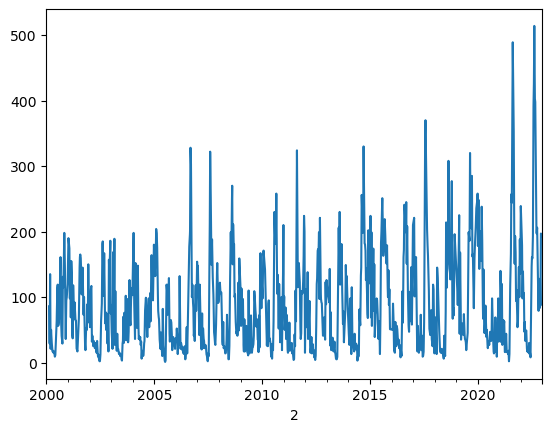

In [13]:
df_modis_le = pd.read_csv(f_modis_le, header=None)
df_modis_le.index = df_modis_le[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
df_modis_le["LE_MODIS"] = df_modis_le[4 + pixel_ind].apply(
    lambda x: float(x) / modis_le_scale_factor if x != "F" else np.nan
)
df_modis_le = df_modis_le[["LE_MODIS"]]
df_modis_le = df_modis_le.resample("30min").interpolate()
df_modis_le["LE_MODIS"].plot()

In [14]:
# df_modis = pd.concat([df_modis_lai, df_modis_le])
df_modis = df_modis_le.join(df_modis_lai)
df_modis.head()

,LE_MODIS,LAI
2,,
2000-01-01 00:00:00,NaN,NaN
2000-01-01 00:30:00,NaN,NaN
2000-01-01 01:00:00,NaN,NaN
2000-01-01 01:30:00,NaN,NaN
2000-01-01 02:00:00,NaN,NaN


In [15]:
# Compute the LAI at the flux tower

In [16]:
# data_json['subset'][5]['data']
# Get MODIS LAI
# start, end = df.index[0], df.index[-1]
# df_modis = get_modis_lai("US-Hn1", start, end, method='mean', sample_freq="30min")
# df_modis, data_json = get_modis_lai(
#   "US-Hn1", start, end, method='mean', sample_freq="30min"
# )
# df_modis["LAI"].plot()

In [17]:
# df_modis = pd.read_csv(f_modis_lai, header=None)
# df_modis.index = df_modis[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
# df_modis["LAI"] = df_modis[6].apply(
#     lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
# )
# df_modis = df_modis[["LAI"]]
# df_modis = df_modis.resample("30min").interpolate()
# df_modis["LAI"].plot()

# Combine data

In [18]:
df = df.join(df_modis)
# df = df.join(df_soil[["Rsoil"]])

In [19]:
df_modis["LAI"]

2
2000-01-01 00:00:00    NaN
2000-01-01 00:30:00    NaN
2000-01-01 01:00:00    NaN
2000-01-01 01:30:00    NaN
2000-01-01 02:00:00    NaN
                      ... 
2022-12-26 22:00:00    0.1
2022-12-26 22:30:00    0.1
2022-12-26 23:00:00    0.1
2022-12-26 23:30:00    0.1
2022-12-27 00:00:00    0.1
Freq: 30T, Name: LAI, Length: 403009, dtype: float64

In [20]:
df

,TIMESTAMP_START,TIMESTAMP_END,TA_F_MDS,TA_F_MDS_QC,TA_ERA,TA_F,TA_F_QC,SW_IN_POT,SW_IN_F_MDS,SW_IN_F_MDS_QC,...,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N,veg_ht,eair,LE_MODIS,LAI
TIMESTAMP_END,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:30:00,200401010000,200401010030,-9999.000,-9999,7.902,7.902,2,0.0,-9999.0,-9999,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.000000,125.713294,0.1
2004-01-01 01:00:00,200401010030,200401010100,-9999.000,-9999,7.832,7.832,2,0.0,-9999.0,-9999,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.000000,125.807540,0.1
2004-01-01 01:30:00,200401010100,200401010130,-9999.000,-9999,7.762,7.762,2,0.0,-9999.0,-9999,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.000000,125.901786,0.1
2004-01-01 02:00:00,200401010130,200401010200,-9999.000,-9999,7.867,7.867,2,0.0,-9999.0,-9999,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.000000,125.996032,0.1
2004-01-01 02:30:00,200401010200,200401010230,-9999.000,-9999,7.972,7.972,2,0.0,-9999.0,-9999,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.000000,126.090278,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 22:00:00,202112312130,202112312200,4.062,0,9.993,4.062,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.758555,226.357143,0.1
2021-12-31 22:30:00,202112312200,202112312230,4.261,0,9.993,4.261,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.731421,226.303571,0.1
2021-12-31 23:00:00,202112312230,202112312300,4.340,0,9.993,4.340,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,-9999,-9999,0.4,0.707544,226.250000,0.1


# Forcings

In [21]:
df[df == -9999] = np.nan

In [22]:
df["Year"] = df.index.year
df["DoY"] = df.index.day_of_year
df["Hour"] = df.index.hour + df.index.minute / 60.0
df["SWC_F_MDS_1"] = df["SWC_F_MDS_1"] / 100.0
df["SWC_F_MDS_2"] = df["SWC_F_MDS_2"] / 100.0

In [23]:
# list(df.keys())
df["TA_F_QC"]

TIMESTAMP_END
2004-01-01 00:30:00    2
2004-01-01 01:00:00    2
2004-01-01 01:30:00    2
2004-01-01 02:00:00    2
2004-01-01 02:30:00    2
                      ..
2021-12-31 22:00:00    0
2021-12-31 22:30:00    0
2021-12-31 23:00:00    0
2021-12-31 23:30:00    0
2022-01-01 00:00:00    0
Name: TA_F_QC, Length: 315600, dtype: int64

In [50]:
# The following information is needed to drive CANOAK
in_varns = [
    "Year",
    "DoY",
    "Hour",
    "TA_F",
    "SW_IN_F",
    "eair",
    "WS_F",
    "CO2_F_MDS",
    "PA_F",
    "USTAR",
    "TS_F_MDS_2",
    # "SWC_F_MDS_2",
    "SWC_F_MDS_1",
    "veg_ht",
    "LAI",
]

<Axes: xlabel='TIMESTAMP_END'>

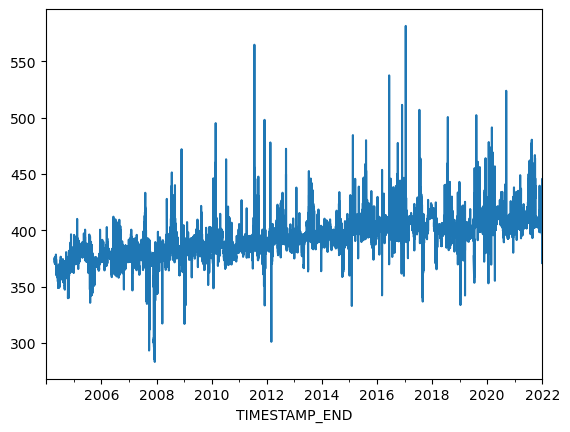

In [25]:
# Clean up the negative CO2 ppm
df.loc[df["CO2_F_MDS"] <= 100, "CO2_F_MDS"] = np.nan
df["CO2_F_MDS"].plot()

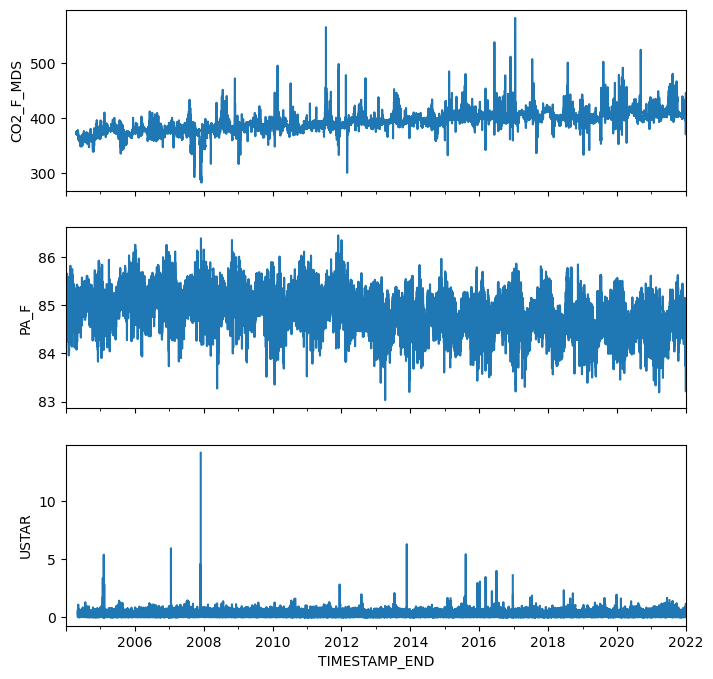

In [26]:
# varns = ["Rsoil", "CO2_F_MDS", "PA_F", "USTAR"]
varns = ["CO2_F_MDS", "PA_F", "USTAR"]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 8), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [48]:
# # plt.scatter(df['SWC_F_MDS_1'][start:end], df['LE_F_MDS'][start:end])
# # plt.scatter(df['SWC_F_MDS_1'][start:end], df['LE_F_MDS'][start:end])
# start, end = "2018-01-01", "2019-12-30"
# plt.scatter(df['SWC_F_MDS_1'][start:end], df['LE_F_MDS'][start:end])

In [49]:
# # varns = ["Rsoil", "CO2_F_MDS", "PA_F", "USTAR"]
# varns = ["SWC_F_MDS_1", "SWC_F_MDS_2", "SWC_F_MDS_3", "LE_F_MDS", "LE_MODIS"]
# start, end = "2010-01-01", "2019-12-30"
# fig, axes = plt.subplots(len(varns), 1, figsize=(8, 8), sharex=True)
# for i, varn in enumerate(varns):
#     ax = axes[i]
#     df[varn][start:end].plot(ax=ax)
#     ax.set(ylabel=varn)

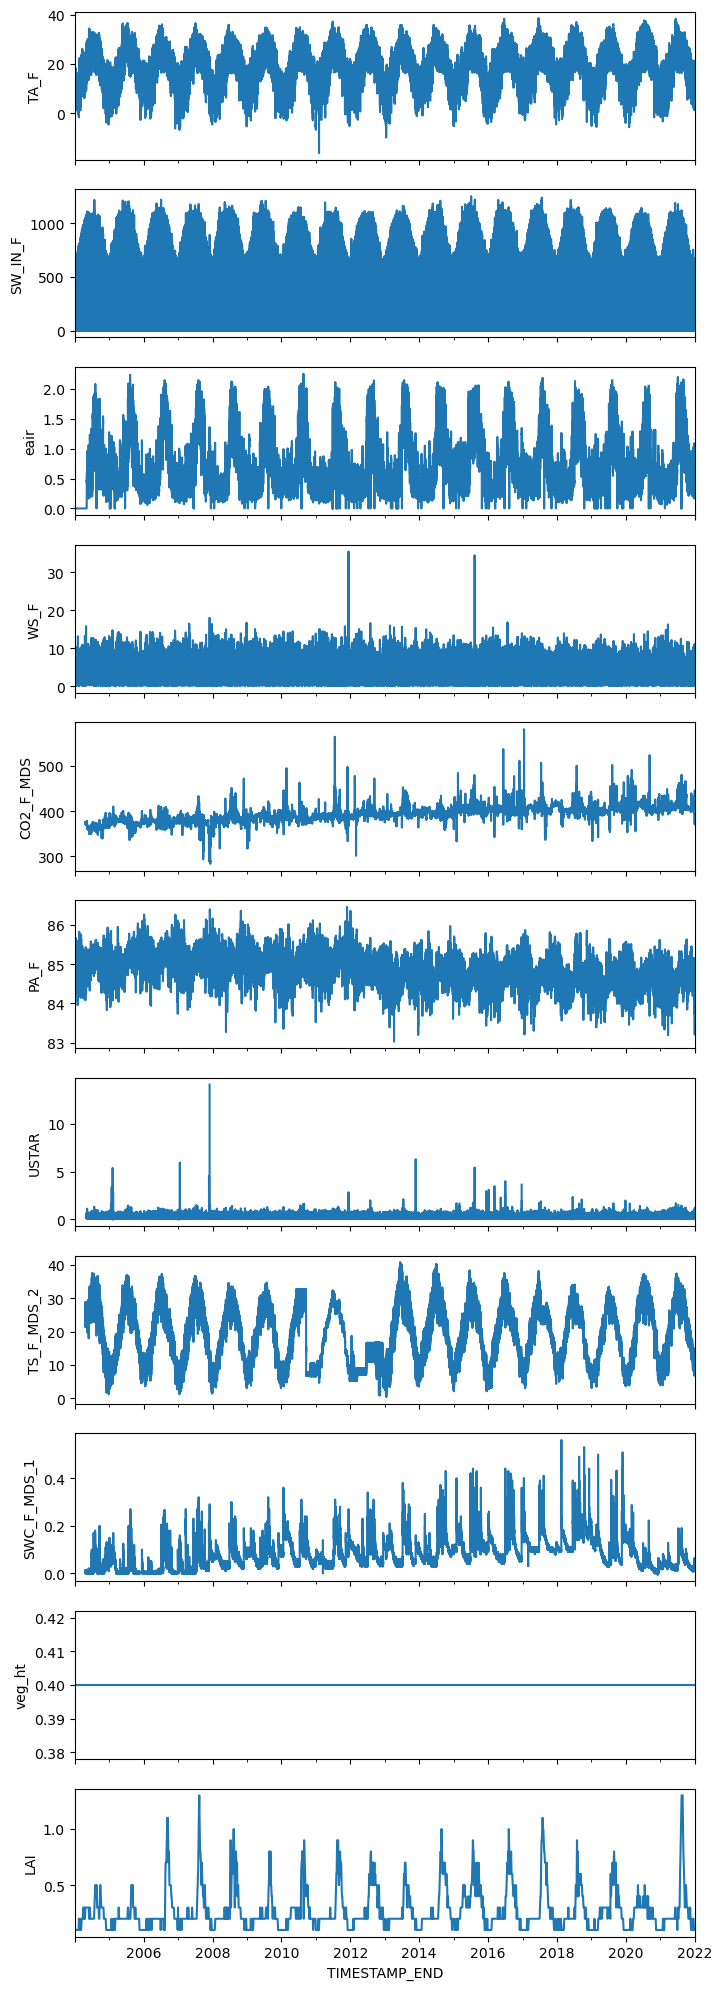

In [51]:
varns = in_varns[3:]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 25), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [52]:
# Save the forcing data
# start, end = "2016-06-01", "2017-06-30"
start, end = "2018-01-01", "2019-12-30"
df_save = df[in_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt(dir_flux_data / "US-Bi1-forcings-short.csv", df_save.values, delimiter=",")
np.savetxt(dir_flux_data / "US-Wkg-forcings.csv", df_save.values, delimiter=",")

In [53]:
# Save the forcing data -- test
# start_test, end_test = "2020-07-01", "2021-12-30"
start_test, end_test = "2020-01-01", "2021-12-30"
df_save = df[in_varns][start_test:end_test]
df_save.interpolate(inplace=True)
np.savetxt(dir_flux_data / "US-Wkg-forcings-test.csv", df_save.values, delimiter=",")

# Responses/fluxes/rain

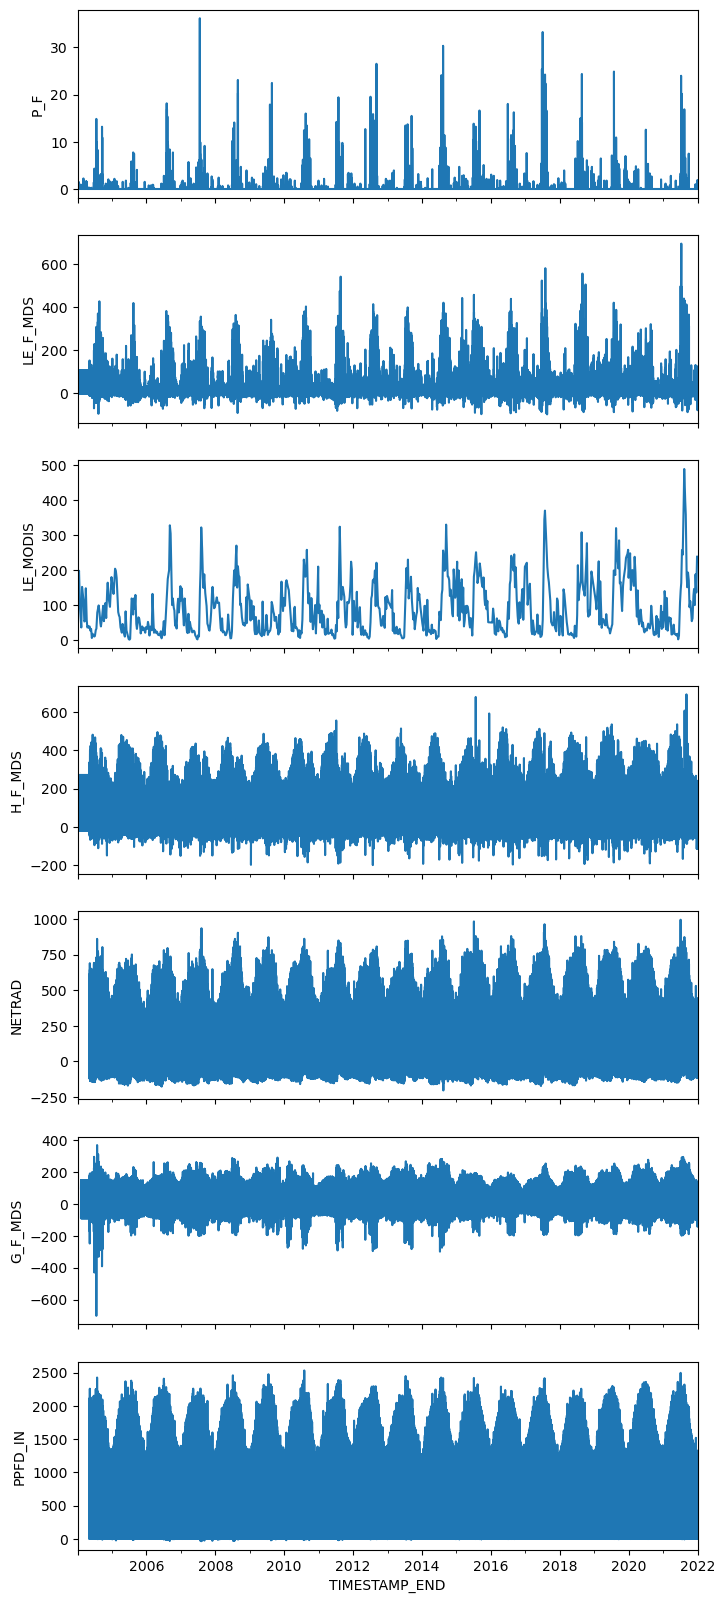

In [32]:
# The data to compare
out_varns = [
    "P_F",
    "LE_F_MDS",
    "LE_MODIS",
    "H_F_MDS",
    "NETRAD",
    "G_F_MDS",
    "PPFD_IN",
    # "Rsoil",
]
varns = out_varns
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 20), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

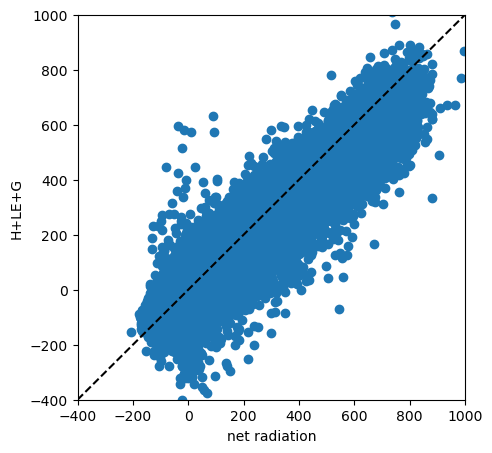

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lim = [-400, 1000]
ax.scatter(df["NETRAD"], df["H_F_MDS"] + df["LE_F_MDS"] + df["G_F_MDS"])
ax.plot(lim, lim, "k--")
ax.set(xlim=lim, ylim=lim, xlabel="net radiation", ylabel="H+LE+G");

In [34]:
df[out_varns][start:end].interpolate()

,P_F,LE_F_MDS,LE_MODIS,H_F_MDS,NETRAD,G_F_MDS,PPFD_IN
TIMESTAMP_END,,,,,,,
2018-01-01 00:00:00,0.0,-0.259873,36.000000,0.829796,-85.60,-13.2658,0.0
2018-01-01 00:30:00,0.0,1.753270,36.085938,17.369800,-86.60,-35.3471,0.0
2018-01-01 01:00:00,0.0,-0.850440,36.171875,-4.588410,-86.50,-32.4270,0.0
2018-01-01 01:30:00,0.0,0.220490,36.257812,-4.541990,-87.00,-27.8520,0.0
2018-01-01 02:00:00,0.0,0.621211,36.343750,1.516470,-87.50,-30.2052,0.0
...,...,...,...,...,...,...,...
2019-12-30 21:30:00,0.0,0.668101,195.666667,5.908650,-65.62,-32.5783,0.0
2019-12-30 22:00:00,0.0,6.844100,195.333333,-38.636600,-88.60,-28.7675,0.0
2019-12-30 22:30:00,0.0,4.940940,195.000000,-24.449600,-89.00,-42.3958,0.0


In [35]:
dir_flux_data

PosixPath('../data/fluxtower/US-Wkg')

In [36]:
# Save the data to compare
df_save = df[out_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
# df_save.to_csv(dir_flux_data / "US-Bi1-fluxes-short.csv", sep=",")
df_save.to_csv(dir_flux_data / "US-Wkg-fluxes.csv", sep=",")

In [37]:
# Save the data to compare -- test
df_save = df[out_varns][start_test:end_test]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
# df_save.to_csv(dir_flux_data / "US-Bi1-fluxes-short.csv", sep=",")
df_save.to_csv(dir_flux_data / "US-Wkg-fluxes-test.csv", sep=",")